# 01 - Ingesta y Limpieza de Datos

**Proyecto:** Seguridad Inteligente con Arduino y Visión Artificial

Este notebook realiza la ingesta de datos desde la exportación de Telegram y ejecuta el proceso de limpieza inicial.

---

## 1. Configuración Inicial

In [20]:
# Importar librerías necesarias
import sys
import os

# Importaciones estándar
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Importar módulo personalizado (ahora definido en la siguiente celda)
# from ingest import TelegramDataIngestor

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Opciones de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [21]:
# Clase TelegramDataIngestor (sustituye al módulo src/ingest.py)
import yaml
from datetime import datetime
from typing import Dict, List, Optional

class TelegramDataIngestor:
    """Clase para ingerir y procesar datos de exportación de Telegram."""
    
    def __init__(self, config_path: str = "configs/config.yaml"):
        """
        Inicializa el ingestor de datos.
        
        Args:
            config_path: Ruta al archivo de configuración YAML
        """
        self.config_path = Path(config_path).resolve()
        with open(self.config_path, 'r') as f:
            self.config = yaml.safe_load(f)
        
        # Base del proyecto = carpeta padre de 'configs/'
        # Ej: .../Proyecto/configs/config.yaml -> project_root = .../Proyecto
        self.project_root = self.config_path.parent.parent
        
        # Resolver rutas del config relativas al root del proyecto
        def _resolve_path(p):
            p = Path(p)
            return p if p.is_absolute() else (self.project_root / p)
        
        self.raw_path = _resolve_path(self.config['data']['raw_path']).resolve()
        self.processed_path = _resolve_path(self.config['data']['processed_path']).resolve()
        self.result_file = self.config['telegram']['result_file']
        
    def load_telegram_export(self) -> Dict:
        """Carga y unifica mensajes desde el export de Telegram.

        Soporta varios formatos habituales:
        - result.json con 'messages' a nivel raíz.
        - result.json con 'chats'->'list' y 'messages' por chat.
        - Carpeta 'chats/' con archivos chat_*.json, cada uno con 'messages'.
        Devuelve un dict con la clave 'messages' conteniendo todos los mensajes unificados.
        """
        file_path = (self.raw_path / self.result_file).resolve()
        if not file_path.exists():
            raise FileNotFoundError(f"No se encontró el archivo: {file_path}")
        
        with open(file_path, 'r', encoding='utf-8') as f:
            root = json.load(f)
        
        all_messages: List[dict] = []
        chats_seen = 0
        
        # 1) Mensajes a nivel raíz
        root_msgs = root.get('messages')
        if isinstance(root_msgs, list):
            all_messages.extend(root_msgs)
        
        # 2) Mensajes dentro de 'chats'->'list'
        chats_block = root.get('chats')
        if isinstance(chats_block, dict):
            chat_list = chats_block.get('list')
            if isinstance(chat_list, list):
                for chat in chat_list:
                    msgs = chat.get('messages')
                    if isinstance(msgs, list):
                        all_messages.extend(msgs)
                        chats_seen += 1
        
        # 3) Archivos en carpeta 'chats/' si existe
        chats_dir = (self.raw_path / 'chats').resolve()
        if chats_dir.exists() and chats_dir.is_dir():
            for p in sorted(chats_dir.glob('*.json')):
                try:
                    with open(p, 'r', encoding='utf-8') as cf:
                        cdata = json.load(cf)
                    msgs = cdata.get('messages')
                    if isinstance(msgs, list):
                        all_messages.extend(msgs)
                        chats_seen += 1
                except Exception as e:
                    print(f"⚠ No se pudo leer {p}: {e}")
        
        print(f"✓ Archivo cargado: {file_path}")
        print(f"  Total de mensajes unificados: {len(all_messages)} (chats procesados: {chats_seen})")
        
        return {"messages": all_messages}

    def _extract_text(self, text) -> str:
        """Extrae el texto de diferentes formatos de mensaje."""
        if isinstance(text, str):
            return text
        elif isinstance(text, list):
            return ' '.join([t if isinstance(t, str) else t.get('text', '') for t in text])
        return ''

    def extract_messages(self, data: Dict) -> pd.DataFrame:
        """Extrae y procesa los mensajes del export de Telegram."""
        messages = data.get('messages', [])
        records = []
        for msg in messages:
            record = {
                'id': msg.get('id'),
                'type': msg.get('type'),
                'date': msg.get('date'),
                'from': msg.get('from'),
                'from_id': msg.get('from_id'),
                'text': self._extract_text(msg.get('text', '')),
                'photo': msg.get('photo'),
                'has_photo': bool(msg.get('photo')),
                'media_type': msg.get('media_type'),
            }
            records.append(record)
        df = pd.DataFrame(records)
        print(f"✓ Extraídos {len(df)} registros")
        return df

    def clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Limpia y procesa el DataFrame de mensajes."""
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['hour'] = df['date'].dt.hour
        df['day_of_week'] = df['date'].dt.dayofweek
        df['day_name'] = df['date'].dt.day_name()
        df = df.drop_duplicates(subset=['id'])
        df = df.sort_values('date').reset_index(drop=True)
        print(f"✓ Datos limpios: {len(df)} registros únicos")
        print(f"  Rango de fechas: {df['date'].min()} a {df['date'].max()}")
        return df

    def save_processed_data(self, df: pd.DataFrame, filename: Optional[str] = None):
        """Guarda los datos procesados en formato CSV."""
        if filename is None:
            filename = self.config['data']['output_file']
        output_path = (self.processed_path / filename).resolve()
        output_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(output_path, index=False, encoding='utf-8')
        print(f"✓ Datos guardados en: {output_path}")

    def run(self):
        print("=== Iniciando ingesta de datos ===\n")
        data = self.load_telegram_export()
        df = self.extract_messages(data)
        df_clean = self.clean_data(df)
        self.save_processed_data(df_clean)
        print("\n=== Ingesta completada ===")
        return df_clean

## 2. Ingesta de Datos

Cargaremos los datos desde el archivo `result.json` exportado de Telegram.

In [22]:
# Inicializar el ingestor
ingestor = TelegramDataIngestor(config_path='../configs/config.yaml')

print("✓ Ingestor inicializado")
print(f"  Ruta de datos raw: {ingestor.raw_path}")
print(f"  Ruta de datos procesados: {ingestor.processed_path}")

✓ Ingestor inicializado
  Ruta de datos raw: C:\Users\SALVADOR\Desktop\Seguridad-Inteligente-con-Arduino-y-Vision-Artificial\data\raw\telegram_export
  Ruta de datos procesados: C:\Users\SALVADOR\Desktop\Seguridad-Inteligente-con-Arduino-y-Vision-Artificial\data\processed


In [23]:
# Cargar archivo de exportación de Telegram
try:
    data = ingestor.load_telegram_export()
    print("\n✓ Datos cargados exitosamente")
    print(f"  Claves disponibles: {list(data.keys())}")
except FileNotFoundError as e:
    print(f"⚠ Error: {e}")
    print("\nPor favor, coloca el archivo 'result.json' en: data/raw/telegram_export/")
    data = None

✓ Archivo cargado: C:\Users\SALVADOR\Desktop\Seguridad-Inteligente-con-Arduino-y-Vision-Artificial\data\raw\telegram_export\result.json
  Total de mensajes unificados: 148 (chats procesados: 4)

✓ Datos cargados exitosamente
  Claves disponibles: ['messages']


## 3. Extracción y Procesamiento de Mensajes

In [24]:
# Extraer mensajes del archivo JSON
if data is not None:
    df_raw = ingestor.extract_messages(data)
    
    print("\n=== Vista previa de los datos crudos ===")
    display(df_raw.head())
    
    print("\n=== Información del DataFrame ===")
    print(df_raw.info())
else:
    print("⚠ No se pueden extraer mensajes sin datos")

✓ Extraídos 148 registros

=== Vista previa de los datos crudos ===


,id,type,date,from,from_id,text,photo,has_photo,media_type
0,402,message,2025-10-22T17:53:02,Salvador BG,user6214146540,/start,None,False,None
1,403,message,2025-10-22T18:00:04,Cam_Salvador,user8053172513,⚠️ Motion Detected!,chats/chat_1/photos/photo_1@22-10-2025_18-00-0...,True,None
2,404,message,2025-10-22T18:00:16,Cam_Salvador,user8053172513,⚠️ Motion Detected!,chats/chat_1/photos/photo_2@22-10-2025_18-00-1...,True,None
3,405,message,2025-10-22T18:00:42,Cam_Salvador,user8053172513,⚠️ Motion Detected!,chats/chat_1/photos/photo_3@22-10-2025_18-00-4...,True,None
4,406,message,2025-10-22T18:00:50,Cam_Salvador,user8053172513,⚠️ Motion Detected!,chats/chat_1/photos/photo_4@22-10-2025_18-00-5...,True,None



=== Información del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          148 non-null    int64 
 1   type        148 non-null    object
 2   date        148 non-null    object
 3   from        148 non-null    object
 4   from_id     148 non-null    object
 5   text        148 non-null    object
 6   photo       135 non-null    object
 7   has_photo   148 non-null    bool  
 8   media_type  0 non-null      object
dtypes: bool(1), int64(1), object(7)
memory usage: 9.5+ KB
None


## 4. Limpieza de Datos

In [25]:
# Limpiar y procesar los datos
if data is not None:
    df_clean = ingestor.clean_data(df_raw)
    
    print("\n=== Datos limpios ===")
    display(df_clean.head())
    
    print("\n=== Estadísticas básicas ===")
    print(f"Total de registros: {len(df_clean)}")
    print(f"Rango de fechas: {df_clean['date'].min()} a {df_clean['date'].max()}")
    print(f"Columnas: {list(df_clean.columns)}")
else:
    print("⚠ No se pueden limpiar datos sin información previa")

✓ Datos limpios: 148 registros únicos
  Rango de fechas: 2024-08-05 09:41:17 a 2025-10-25 01:03:27

=== Datos limpios ===


,id,type,date,from,from_id,text,photo,has_photo,media_type,year,month,day,hour,day_of_week,day_name
0,235,message,2024-08-05 09:41:17,Voluntarios de soporte,user450000,🔹 La mayor parte de las preguntas ya han sido ...,None,False,None,2024,8,5,9,0,Monday
1,234,message,2024-08-05 09:41:17,Salvador BG,user6214146540,/start,None,False,None,2024,8,5,9,0,Monday
2,393,message,2025-10-22 17:48:15,BotFather,user93372553,I can help you create and manage Telegram bots...,None,False,None,2025,10,22,17,2,Wednesday
3,392,message,2025-10-22 17:48:15,Salvador BG,user6214146540,/start,None,False,None,2025,10,22,17,2,Wednesday
4,395,message,2025-10-22 17:48:40,BotFather,user93372553,"Alright, a new bot. How are we going to call i...",None,False,None,2025,10,22,17,2,Wednesday



=== Estadísticas básicas ===
Total de registros: 148
Rango de fechas: 2024-08-05 09:41:17 a 2025-10-25 01:03:27
Columnas: ['id', 'type', 'date', 'from', 'from_id', 'text', 'photo', 'has_photo', 'media_type', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_name']


## 5. Exploración Rápida

In [26]:
# Verificar valores nulos
if 'df_clean' in locals():
    print("=== Valores nulos por columna ===")
    null_counts = df_clean.isnull().sum()
    print(null_counts[null_counts > 0])
    
    if null_counts.sum() == 0:
        print("✓ No hay valores nulos")

=== Valores nulos por columna ===
photo          13
media_type    148
dtype: int64


=== Distribución de tipos de mensajes ===
type
message    148
Name: count, dtype: int64


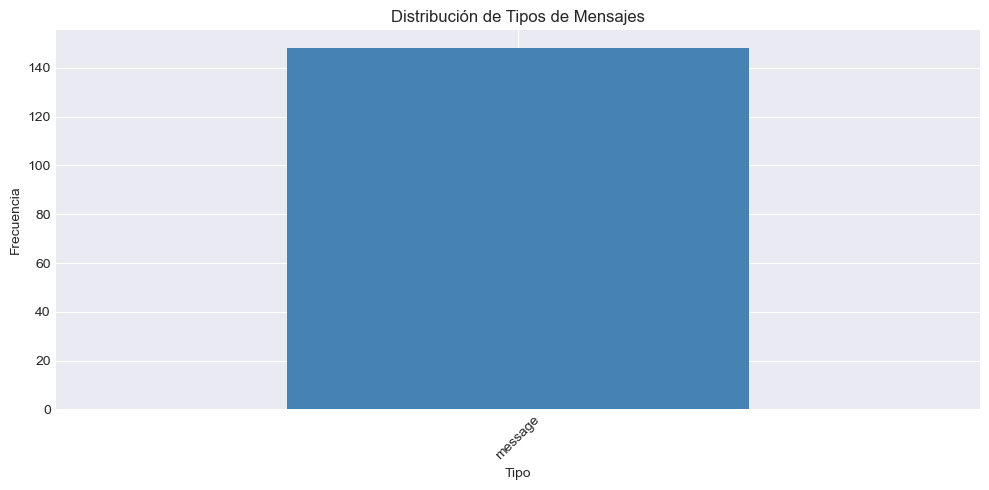

In [27]:
# Distribución de tipos de mensajes
if 'df_clean' in locals() and 'type' in df_clean.columns:
    print("=== Distribución de tipos de mensajes ===")
    print(df_clean['type'].value_counts())
    
    # Visualización
    plt.figure(figsize=(10, 5))
    df_clean['type'].value_counts().plot(kind='bar', color='steelblue')
    plt.title('Distribución de Tipos de Mensajes')
    plt.xlabel('Tipo')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [28]:
# Eventos con fotos
if 'df_clean' in locals() and 'has_photo' in df_clean.columns:
    print("=== Eventos con fotografías ===")
    photo_counts = df_clean['has_photo'].value_counts()
    print(photo_counts)
    print(f"\nPorcentaje con fotos: {(photo_counts.get(True, 0) / len(df_clean) * 100):.2f}%")

=== Eventos con fotografías ===
has_photo
True     135
False     13
Name: count, dtype: int64

Porcentaje con fotos: 91.22%


## 6. Guardar Datos Procesados

In [29]:
# Guardar el DataFrame limpio
if 'df_clean' in locals():
    ingestor.save_processed_data(df_clean)
    print("\n✓ Datos guardados exitosamente")
    print(f"  Archivo: {ingestor.processed_path / ingestor.config['data']['output_file']}")
else:
    print("⚠ No hay datos para guardar")

✓ Datos guardados en: C:\Users\SALVADOR\Desktop\Seguridad-Inteligente-con-Arduino-y-Vision-Artificial\data\processed\events_clean.csv

✓ Datos guardados exitosamente
  Archivo: C:\Users\SALVADOR\Desktop\Seguridad-Inteligente-con-Arduino-y-Vision-Artificial\data\processed\events_clean.csv


## 7. Resumen

In [30]:
# Resumen final
if 'df_clean' in locals():
    print("=" * 60)
    print("RESUMEN DE INGESTA Y LIMPIEZA")
    print("=" * 60)
    print(f"✓ Registros totales: {len(df_clean)}")
    print(f"✓ Columnas: {len(df_clean.columns)}")
    print(f"✓ Rango temporal: {(df_clean['date'].max() - df_clean['date'].min()).days} días")
    print(f"✓ Datos guardados en: data/processed/events_clean.csv")
    print("\n✓ Proceso completado exitosamente")
    print("\nPróximo paso: Ejecutar notebook 02_eda_y_features.ipynb")
    print("=" * 60)
else:
    print("⚠ El proceso no se completó. Verifica que los datos estén disponibles.")

RESUMEN DE INGESTA Y LIMPIEZA
✓ Registros totales: 148
✓ Columnas: 15
✓ Rango temporal: 445 días
✓ Datos guardados en: data/processed/events_clean.csv

✓ Proceso completado exitosamente

Próximo paso: Ejecutar notebook 02_eda_y_features.ipynb
